# 0. Set-up

In [15]:
import os
import re
import sys
import pickle
import importlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter

import osmnx as ox 
import networkx as nx
from shapely.geometry import Point, Polygon, LineString

import time
import igraph as iG
from igraph import Graph

import plotly as py
import plotly.graph_objs as go

def reload_module(module):
    importlib.reload(module)

# Specify the directory containing the .py modules
module_dir = "../modules"

# Add the directory to the Python path
sys.path.append(os.path.abspath(module_dir))

def value_formatter(x, pos=None):
    # Format with commas as thousand separators
    return f"{abs(int(x)):,}" if x == int(x) else f"{abs(x):,.2f}"

# 1. Load Knowledge Base & Map Resources

In [2]:
import datasets

reload_module(datasets)
from datasets import KnowledgeBase

import map_resources

reload_module(map_resources)
from map_resources import MapResources

In [3]:
# A wide dataframe for PUBLIC schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_public_datasets.csv'
public = pd.read_csv(fpath, index_col='school_id')
# print(public.shape)

# A wide dataframe for PRIVATE schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_private_datasets.csv'
private = pd.read_csv(fpath, index_col='school_id')
# print(private.shape)

# Initialize class that also preloads and reorganizes PSGC shapefiles
mr = MapResources(preloaded=True)

# The gpd_gadm is the dataframe of the shapefiles of Philippines following PSGC with EPSG:4326
gpd_gadm = mr.gadm.copy()

# The output is a dictionary of complete filepaths where the keys are the PSGC region names
# of our 17 regions. These are OSMNX drive graph networks
mr.get_filepaths_of_regional_road_networks()

# Additional preprocessing is done on our compiled public & private datasets
gdf_public = mr.preprocess_public_school_coordinates_further(public)
gdf_private = mr.preprocess_private_school_coordinates_further(private)

# 2. Build School Networks
* * *
We will use our `optimized_network_builder` module to facilitate the preparation and generation of the graph network of our schools using our compiled knowledge base and organized shapefiles. We provide a high-level overview below of how the project generates a graph network of schools.

<dl>
    Given the PSGC code of a target region:
    <ol type="1">
      <li>We get the shapefiles/geographies of the target region and its adjacent localities</li>
      <li>Using the above shapefiles, we extract the public and private schools in the target region and extract private schools that fall within the target and adjacent areas</li>
      <li>Still using the shapefiles, we cutout the drive network from our preloaded & locally saved OSMNX graph networks</li>
      <li>Feed the following to our network builder:
        <ol type="1">
          <li>Target & adjacent shapefiles</li>
          <li>Public and private schools</li>
          <li>Drive graph network</li>
        </ol>
      </li>
      <li>Run network builder algorithm</li>
    </ol>
</dl>

For this notebook, we demonstrate the generation of a network of schools in Region IV-A.

In [4]:
import optimized_network_builder

reload_module(optimized_network_builder)
from optimized_network_builder import OptimizedSchoolNetworkBuilder

## 2.1. Region IV-A

### 2.1.1. Extract geographies

We extract the shapes of our target geography and its adjacent geographies. `max_depth` here determines how far the algorithm will crawl outward from the target region when extracting adjacent geographies.

In [5]:
target_psgc = '0400000000' # Region IV-A
max_depth = 3
geo_results = mr.get_adjacent_geographies(
    gpd_gadm=gpd_gadm, 
    target_psgc=target_psgc, 
    max_depth=max_depth
)

Finding adjacent geographies for PSGC 0400000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 62 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 101 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 136 adjacent areas at depth 3
Geography processing completed in 8.88 seconds


In [6]:
# We display the content of geo_results for reference
geo_results.keys()

dict_keys(['target_area', 'adjacent_areas', 'search_area_complete', 'target_shape', 'adjacent_shapes', 'search_shape_complete'])

<dl>
To provide a brief description of the contents of <strong>geo_results</strong>:
    <ol>
        <li>target_area: A GeoDataFrame containing the polygons of the target geography</li>
        <li>adjacent_areas: A dictionary whose keys are 1,2,3 (for max_depth of 3) whose values are GeoDataFrames containing the polygons of the adjacent geographies to the target</li>
        <li>search_area_complete: A GeoDataFrame containing the polygons of the target and adjacent geographies</li>
        <li>target_shape, adjacent_shapes, & search_shape_complete: A .unary_union of the above GeoDataFrames</li>
    </ol>
</dl>

### 2.1.2. Extract public & private schools

In [7]:
%%time
# Extracting schools using extracted geographies
school_results = mr.extract_schools_from_geographies(
    geography_results=geo_results,
    gdf_public=gdf_public,
    gdf_private=gdf_private
)

Extracting schools from geographies...
Prepared geometries in 0.00 seconds
Extracting public schools...
Public target query completed in 0.07 seconds
Found 3548 public schools in target area
Public adjacent depth 1 query completed in 0.02 seconds
Found 118 public schools in adjacent areas at depth 1
Public adjacent depth 2 query completed in 0.02 seconds
Found 174 public schools in adjacent areas at depth 2
Public adjacent depth 3 query completed in 0.02 seconds
Found 203 public schools in adjacent areas at depth 3
Extracting private schools...
Private search area query completed in 339.63 seconds
Found 2653 private schools in the entire search area
Private target query completed in 0.02 seconds
Found 1950 private schools in target area
Private adjacent depth 1 query completed in 0.01 seconds
Found 193 private schools in adjacent areas at depth 1
Private adjacent depth 2 query completed in 0.02 seconds
Found 296 private schools in adjacent areas at depth 2
Private adjacent depth 3 quer

In [8]:
# We display the content of geo_results for reference
school_results.keys()

dict_keys(['public_schools_in_target', 'public_schools_in_adjacent', 'private_schools_in_target', 'private_schools_in_adjacent', 'private_schools_all'])

We categorize schools (public and private) within the target geography as `origin` and schools adjacent to the target as `destination`. This is to facilitate our pathing algorithm later from one origin school to many destination schools.

We then plot our search area along with our extracted public and private schools to inspect if we, more or less, captured what we need in our target region.

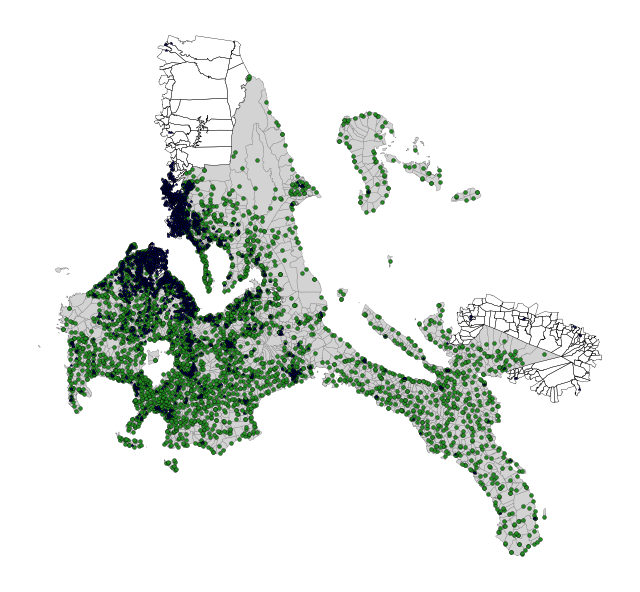

CPU times: user 2.43 s, sys: 179 ms, total: 2.61 s
Wall time: 2.41 s


In [9]:
%%time
fig, ax = plt.subplots(figsize=(8,8))

geo_results['target_area'].plot(
    ax=ax, facecolor='lightgrey', edgecolor='gray',
    linewidth=.25
)
for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.plot(
        ax=ax, facecolor='none', edgecolor='black',
        linewidth=.25
    )

school_results['public_schools_in_target'].plot(
    ax=ax, facecolor='forestgreen',
    edgecolor='black', linewidth=.25,
    marker='.', markersize=30
)
school_results['private_schools_all'].plot(
    ax=ax, facecolor='navy',
    edgecolor='black', linewidth=.25,
    marker='*', markersize=5
)

ax.axis('off')

plt.show()

### 2.1.3. Extract drive graph network

In [10]:
# We cull a subgraph from locally saved regional drive graph networks
G_sub = mr.generate_subgraph(geo_results)

Generating subgraph from geo_results
Subgraph extracted. Time elapsed: 2.51 minutes


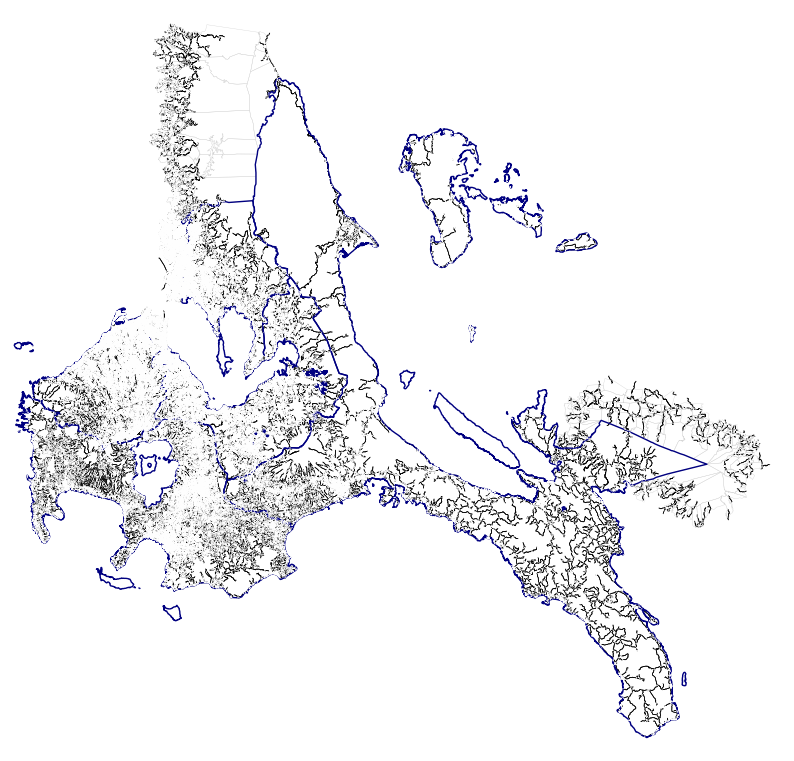

CPU times: user 56.2 s, sys: 610 ms, total: 56.8 s
Wall time: 56.6 s


In [11]:
%%time
# For sanity, we plot our geographies and subgraph road network
fig, ax = ox.plot_graph(
    G_sub, figsize=(10,10),
    node_size=.5, edge_linewidth=.5,
    bgcolor='none', show=False, close=False,
    node_zorder=4, edge_color='black',
)

geo_results['target_area'].dissolve(by='adm2_psgc').plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=1, alpha=1, zorder=3
)

df_adjs = []
for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.plot(
        ax=ax, facecolor='none', edgecolor='lightgrey',
        linewidth=.25, zorder=2
    )
    df_adjs.append(df_adj)
df_adjs = pd.concat(df_adjs)

plt.show()

### 2.1.4. Build network

Overall, we make three groups of schools, namely: 1) public schools within target geography, 2) private schools within target geography, and 3) public and private schools in adjacent geographies.

In [11]:
# We explicitly identify the major groups that will comprise the school network
# This will be removed in the future since we will connect schools with each other regardless of groups
public_in_city = school_results['public_schools_in_target'].copy()
print(public_in_city.shape)

# My private dataframe has columns with "validated" coordinates - we explicitly call them here
private_in_space = school_results['private_schools_in_target'].copy()
private_in_space = private_in_space.drop(columns=['longitude','latitude'])
private_in_space = private_in_space.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)
print(private_in_space.shape)

# Public schools adjacent
adjacent_dfs = [v for k,v in school_results['public_schools_in_adjacent'].items()]
public_periph = pd.concat(adjacent_dfs)
# print(public_periph.shape)

# Private schools adjacent
adjacent_dfs = [v for k,v in school_results['private_schools_in_adjacent'].items()]
private_periph = pd.concat(adjacent_dfs)
private_periph = private_periph.drop(columns=['longitude','latitude'])
private_periph = private_periph.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)
# print(private_periph.shape)

# A dataframe of adjacent PUBLIC and PRIVATE schools
all_periph = pd.concat([public_periph, private_periph])
print(all_periph.shape)

(3548, 25)
(1950, 41)
(1198, 42)


In [19]:
# Initialize the optimized builder
network_builder = OptimizedSchoolNetworkBuilder(
    road_network_graph=G_sub,
    public_schools_gdf=public_in_city.reset_index(),
    private_schools_gdf=private_in_space.reset_index(),
    peripheral_schools_gdf=all_periph.reset_index(),
    admin_boundary=geo_results['target_area'],
    num_processes=None  # None means parallelization will use all available CPUs
)

In [20]:
%%time
# Build the complete network in one call
results = network_builder.build_complete_network(
    buffer_distance_m=5000,
    max_distance_km=15
)

🚀 Starting optimized network build...
📊 Setting up master infrastructure...
School counts: Public=3548, Private=1950, Peripheral=1198
Combined 6696 total schools
🔄 Converting NetworkX to iGraph...
Projected graph: 380100 nodes, 985152 edges
Created iGraph with 380100 vertices and 985152 edges
🔄 Creating WGS84 version of master iGraph...
Created iGraph with 380100 vertices and 985152 edges
Created 4326 iGraph with 380100 vertices
🗺️  Mapping schools to road network vertices...
Mapping results: 6696 successful, 0 failed
✅ Master graph: 380100 vertices, 985152 edges
✅ Master graph 4326: 380100 vertices
✅ Mapped 6696 schools to road network
🌍 Building spatial indices...
✅ Built spatial indices for 3 school types

🐛 DEBUG: Testing single school...
Testing school ID: 107329
✅ School 107329 mapped to vertex 331832
Found 10 nearby schools: [107318, 107329, 107334, 107319, 342211]...
Distance matrix shape: (1, 5)
Distance matrix:
         107318  107329    107334    107319    342211
107329  525

Total runtime (as of July 3, 2025): 2min 55s

We save the network of schools that we generated (found in the dictionary object `results`) in a pickle file so we do not have to rerun 
the network builder algorithm when we compute network statistics in the future.

In [21]:
%%time
save_path = '../output/gnet_Region4A_07-02-2025.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(results, file)

CPU times: user 4.47 s, sys: 219 ms, total: 4.69 s
Wall time: 8.87 s


We then load the pickle file and display the contents of `results`.

In [23]:
%%time
load_path = '../output/gnet_Region4A_07-02-2025.pkl'
with open(load_path, 'rb') as file: # Open the file in binary read mode ('rb')
    results = pickle.load(file) # Load the dictionary from the file

print(results.keys())

dict_keys(['distance_matrix', 'routes', 'master_graph', 'master_graph_4326', 'school_mappings', 'pruned_graph'])
CPU times: user 2.23 s, sys: 329 ms, total: 2.56 s
Wall time: 6.12 s


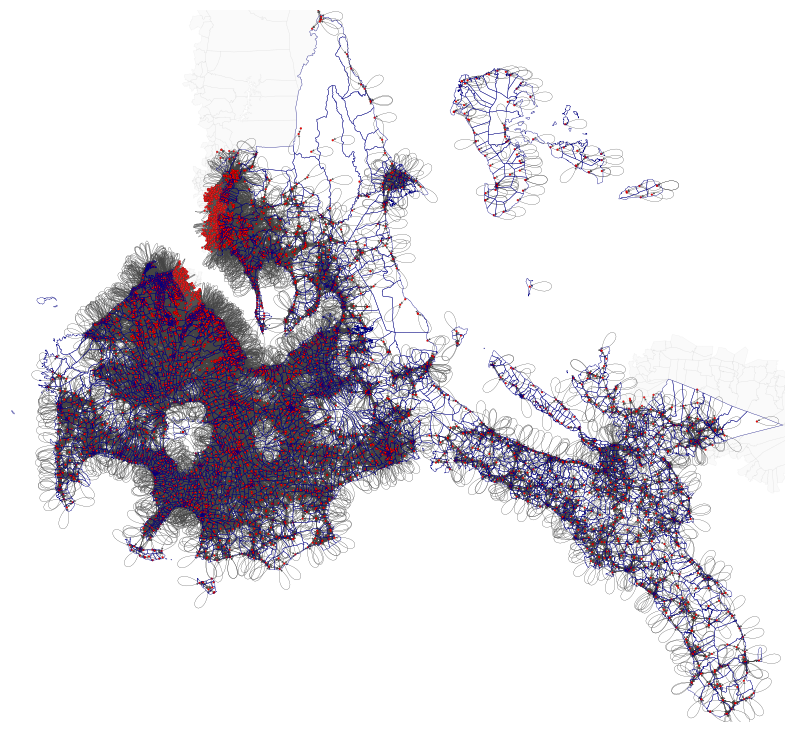

In [16]:
%%time
# Sanity check if we capture our schools in Rizal
fig, ax = plt.subplots(figsize=(10,10))

mult_savefig = 1
# Plot network anchored on the schools' lon-lat
iG.plot(
    results['pruned_graph'],
    target=ax, # **visual_style,
    vertex_size=2*mult_savefig,
    vertex_frame_width=.1,
    edge_width=.1,           # Make edges thicker
    edge_arrow_size=2*mult_savefig,      # Control arrow size
    edge_arrow_width=2*mult_savefig,     # Control arrow width
    bbox=(1000,1000),
    margin=0
)

geo_results['target_area'].to_crs(3123).plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=.25, alpha=1,
)

df_adjs = []
for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.to_crs(3123).plot(
        ax=ax, facecolor='lightgray', edgecolor='grey',
        linewidth=.25, alpha=.1
    )
    df_adjs.append(df_adj.to_crs(3123))
df_adjs = pd.concat(df_adjs)

df_cm = geo_results['target_area'].to_crs(3123).copy()
cm_3123_shp = df_cm.unary_union # This is 4326

min_x, min_y, max_x, max_y = cm_3123_shp.bounds
multiplier = 0.001
ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

# plt.savefig(
#     '../output/up_pascn/rizal_network_general.png',
#     dpi=400, transparent=True, bbox_inches ='tight',
# )

plt.show()